<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Обучение</a></span></li><li><span><a href="#Выводы" data-toc-modified-id="Выводы-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Выводы</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

# Проект для «Викишоп»

Интернет-магазин «Викишоп» запускает новый сервис. Теперь пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах. То есть клиенты предлагают свои правки и комментируют изменения других. Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию. 

Обучите модель классифицировать комментарии на позитивные и негативные. В вашем распоряжении набор данных с разметкой о токсичности правок.

Постройте модель со значением метрики качества *F1* не меньше 0.75. 

**Инструкция по выполнению проекта**

1. Загрузите и подготовьте данные.
2. Обучите разные модели. 
3. Сделайте выводы.

Для выполнения проекта применять *BERT* необязательно, но вы можете попробовать.

**Описание данных**

Данные находятся в файле `toxic_comments.csv`. Столбец *text* в нём содержит текст комментария, а *toxic* — целевой признак.

In [1]:
#!pip install imbalanced-learn -q
#!pip install wordcloud
#!pip install swifter - q
#!pip install xgboost

In [2]:
import pandas as pd
from tqdm import notebook
import re
from time import time 
import torch
import swifter
import transformers
import nltk
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords
import numpy as np
from numpy.random import default_rng
import transformers
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score, classification_report
from __future__ import unicode_literals, print_function
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import FixedThresholdClassifier
from sklearn.feature_extraction.text import CountVectorizer

In [3]:
from wordcloud import WordCloud

In [4]:
nltk.download('punkt_tab')
nltk.download('stopwords')

[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\igor.grenaderov\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\igor.grenaderov\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [5]:
RANDOM_STATE = 88

## Подготовка

In [6]:
url = 'https://code.s3.yandex.net/datasets/toxic_comments.csv'

In [7]:
df = pd.read_csv(url)

In [8]:
df.head()

,Unnamed: 0,text,toxic
0,0,Explanation\nWhy the edits made under my usern...,0
1,1,D'aww! He matches this background colour I'm s...,0
2,2,"Hey man, I'm really not trying to edit war. It...",0
3,3,"""\nMore\nI can't make any real suggestions on ...",0
4,4,"You, sir, are my hero. Any chance you remember...",0


In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159292 entries, 0 to 159291
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   Unnamed: 0  159292 non-null  int64 
 1   text        159292 non-null  object
 2   toxic       159292 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 3.6+ MB


In [10]:
df.drop('Unnamed: 0', axis=1, inplace=True)

In [11]:
df['text'].duplicated().sum()

0

In [12]:
df.isna().sum()

text     0
toxic    0
dtype: int64

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159292 entries, 0 to 159291
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    159292 non-null  object
 1   toxic   159292 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 2.4+ MB


In [14]:
def w_count(dataframe, df_cleaning=False, stop_words_filtered = False):

    if df_cleaning == True:
        dataframe = dataframe.str.lower()
        display('text lowered')
        dataframe = dataframe.swifter.apply(lambda x: re.sub(r'\W', ' ', x))
        display('only words in text ')
        dataframe = dataframe.swifter.apply(lambda x: re.sub(r'\s+', ' ', x))
        display('text is striped')
        
    
    word2count = {}
    
    for data in dataframe:
        words = nltk.word_tokenize(data)
        for word in words:
            if word not in word2count:
                word2count[word] = 1
            else:
                word2count[word] += 1

    if stop_words_filtered == True:
        display('stop words are removed')
        stop_words = set(stopwords.words('english'))
        filtered_word2count = {word: count for word, count in word2count.items() if word not in stop_words}
        word_freq_df = pd.DataFrame(list(filtered_word2count.items()), columns=['Word', 'Frequency'])
        word_freq_df = word_freq_df.sort_values(by='Frequency', ascending=False)
    else:
        filtered_word2count = {word: count for word, count in word2count.items()}
        word_freq_df = pd.DataFrame(list(filtered_word2count.items()), columns=['Word', 'Frequency'])
        word_freq_df = word_freq_df.sort_values(by='Frequency', ascending=False)

    return word_freq_df

In [15]:
df_toxic = df[df['toxic']==1]#['text']

In [16]:
df_non_toxic = df[df['toxic']==0]#['text']

In [17]:
words_w_trash = w_count(
    df['text'],
    df_cleaning=False)

In [18]:
words_w_trash0 = w_count(
    df_non_toxic['text'],
    df_cleaning=False)

In [19]:
words_w_trash1 = w_count(
    df_toxic['text'],
    df_cleaning=False)

In [20]:
words_wo_trash = w_count(
    df['text'],
    df_cleaning=True)

'text lowered'

Pandas Apply:   0%|          | 0/159292 [00:00<?, ?it/s]

'only words in text '

Pandas Apply:   0%|          | 0/159292 [00:00<?, ?it/s]

'text is striped'

In [21]:
words_wo_trash0 = w_count(
    df_non_toxic['text'],
    df_cleaning=True)

'text lowered'

Pandas Apply:   0%|          | 0/143106 [00:00<?, ?it/s]

'only words in text '

Pandas Apply:   0%|          | 0/143106 [00:00<?, ?it/s]

'text is striped'

In [22]:
words_wo_trash1 = w_count(
    df_toxic['text'],
    df_cleaning=True)

'text lowered'

Pandas Apply:   0%|          | 0/16186 [00:00<?, ?it/s]

'only words in text '

Pandas Apply:   0%|          | 0/16186 [00:00<?, ?it/s]

'text is striped'

In [23]:
words_wo = w_count(
    df['text'],
    df_cleaning=True,
    stop_words_filtered=True)

'text lowered'

Pandas Apply:   0%|          | 0/159292 [00:00<?, ?it/s]

'only words in text '

Pandas Apply:   0%|          | 0/159292 [00:00<?, ?it/s]

'text is striped'

'stop words are removed'

In [24]:
words_wo0 = w_count(
    df_non_toxic['text'],
    df_cleaning=True,
    stop_words_filtered = True)

'text lowered'

Pandas Apply:   0%|          | 0/143106 [00:00<?, ?it/s]

'only words in text '

Pandas Apply:   0%|          | 0/143106 [00:00<?, ?it/s]

'text is striped'

'stop words are removed'

In [25]:
words_wo1 = w_count(
    df_non_toxic['text'],
    df_cleaning=True,
    stop_words_filtered=True)

'text lowered'

Pandas Apply:   0%|          | 0/143106 [00:00<?, ?it/s]

'only words in text '

Pandas Apply:   0%|          | 0/143106 [00:00<?, ?it/s]

'text is striped'

'stop words are removed'

In [26]:
def bars(df_list):
    
    fig, ax = plt.subplots(1,3,figsize=(12,8))
    
    ax[0].barh(df_list[0]['Word'],df_list[0]['Frequency'])
    ax[1].barh(df_list[1]['Word'],df_list[1]['Frequency'])
    ax[2].barh(df_list[2]['Word'],df_list[2]['Frequency'])

    

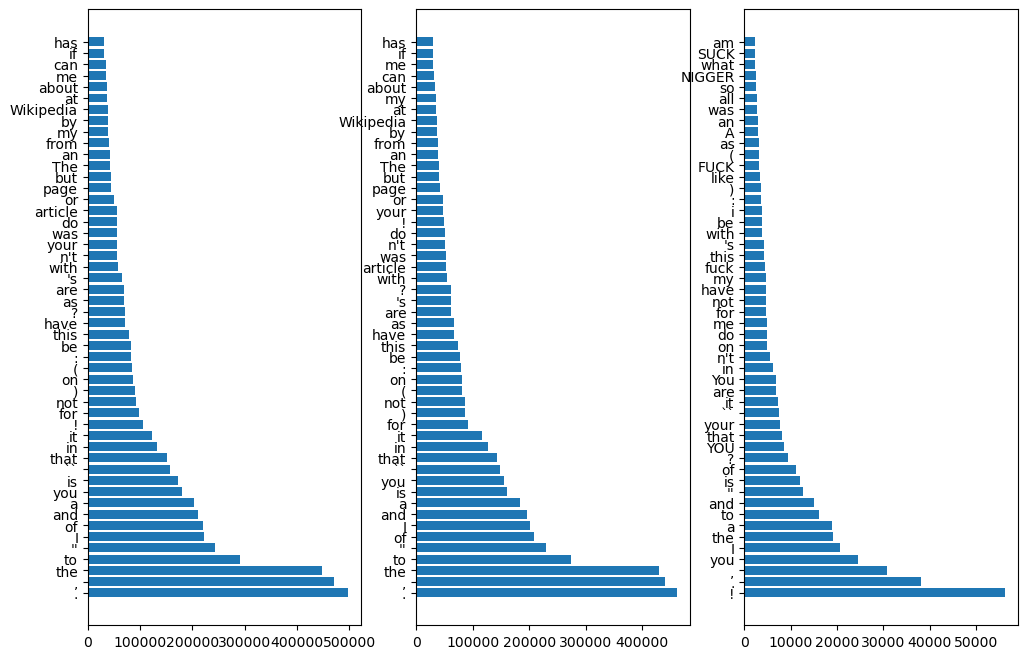

In [27]:
bars([words_w_trash.head(50),words_w_trash0.head(50),words_w_trash1.head(50)])

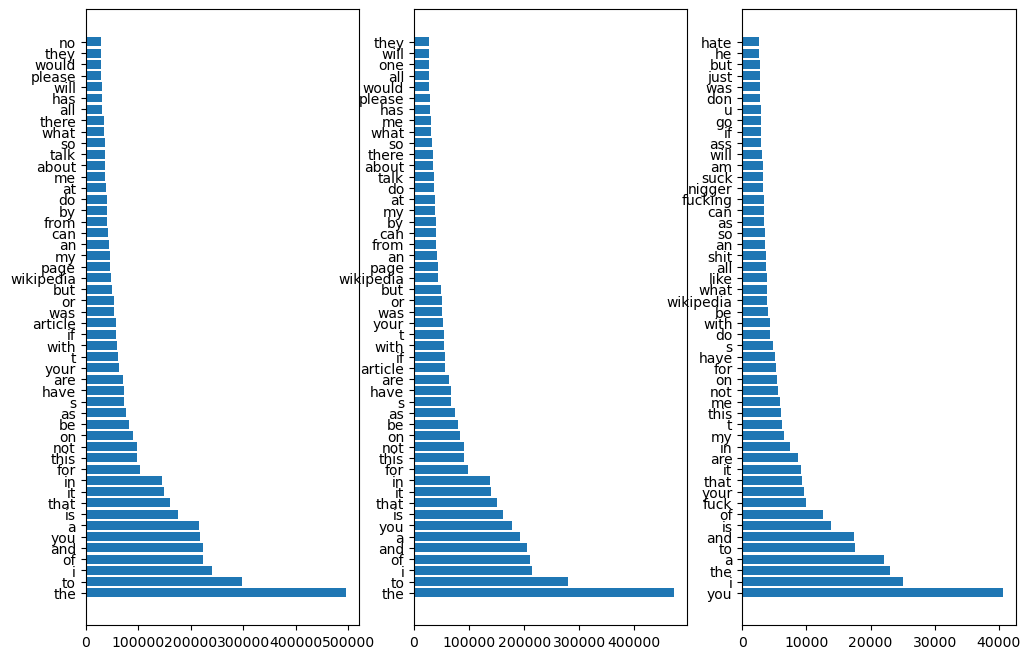

In [28]:
bars([words_wo_trash.head(50),words_wo_trash0.head(50),words_wo_trash1.head(50)])

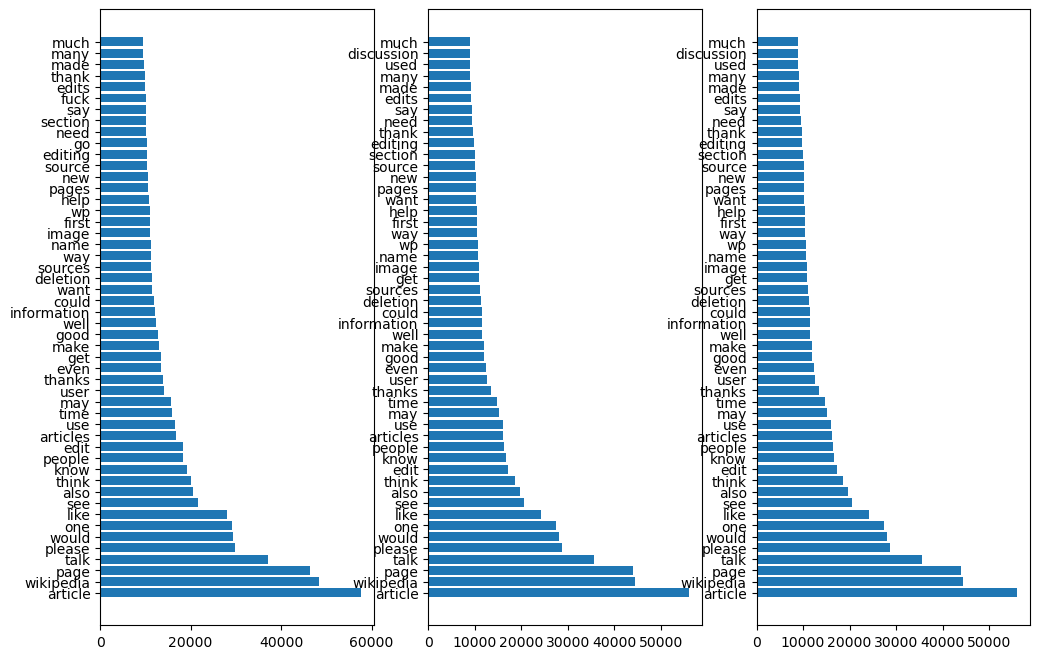

In [29]:
bars([words_wo.head(50),words_wo0.head(50),words_wo1.head(50)])

In [30]:
for item in [words_wo_trash,words_wo_trash0,words_wo_trash1]:
    display(item[item['Frequency']>1].tail(50))

,Word,Frequency
71440,detritus,2
181333,cswf,2
51148,acps110,2
127916,4302,2
129013,daniweb,2
68900,thalberg,2
109501,sîrbu,2
71372,overtonese,2
109073,signifes,2
71444,8508,2


,Word,Frequency
46705,grice,2
64891,kante4,2
67545,websearch,2
112350,dekimasu,2
171249,geezer,2
67560,mily,2
64874,lbmixpro,2
163626,ajf,2
19149,arrius,2
64587,anchovies,2


,Word,Frequency
22876,deservedly,2
27064,gawk,2
32254,ashcroft,2
12675,dirrell,2
32315,halal,2
12664,varies,2
27103,pinch,2
12345,abf,2
12531,throbbing,2
22878,jackbrootjss,2


In [31]:
for item in [words_w_trash,words_w_trash0,words_w_trash1]:
    display(item[item['Frequency']>1].tail(50))

,Word,Frequency
54523,Cdrkit,2
178862,Lizst,2
272140,chitto,2
290094,Chronophage,2
210247,Soyyocdcover.jpg,2
204843,Lambchop,2
272139,bogue,2
16075,slumping,2
90970,Grime,2
221124,Guttmacher,2


,Word,Frequency
71951,camden,2
65988,post-surgical,2
74982,playnext,2
65881,pro-western,2
103825,marque,2
72467,question==,2
105103,grievously,2
261619,Dlabtot,2
74046,Gothenburg,2
105157,ShadowFox,2


,Word,Frequency
8057,boxrec,2
15898,GEEKY,2
48028,Tresman,2
27770,Overall,2
8044,calmed,2
15894,IZAK,2
15893,mastered,2
37385,Aubie,2
40765,CAROLINE,2
8046,Summary,2


In [32]:
def nl_split(string):
    string = re.split('\n+',string)
    result = [sent_tokenize(i.strip()) for i in string]
    return sum(result,[])

In [33]:
df['word_count'] = df['text'].swifter.apply(lambda x: len(word_tokenize(x)))

Pandas Apply:   0%|          | 0/159292 [00:00<?, ?it/s]

In [34]:
df['sent_count'] = df['text'].swifter.apply(lambda x: len(sent_tokenize(x)))

Pandas Apply:   0%|          | 0/159292 [00:00<?, ?it/s]

In [35]:
df['len'] = df['text'].swifter.apply(lambda x: len(x))

Pandas Apply:   0%|          | 0/159292 [00:00<?, ?it/s]

<Axes: >

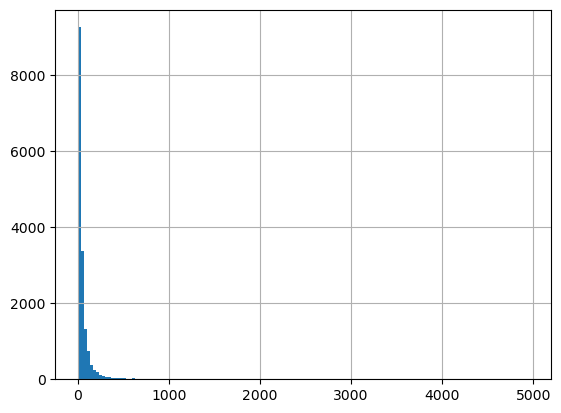

In [36]:
df[df['toxic']==1]['word_count'].hist(bins=150)

<Axes: >

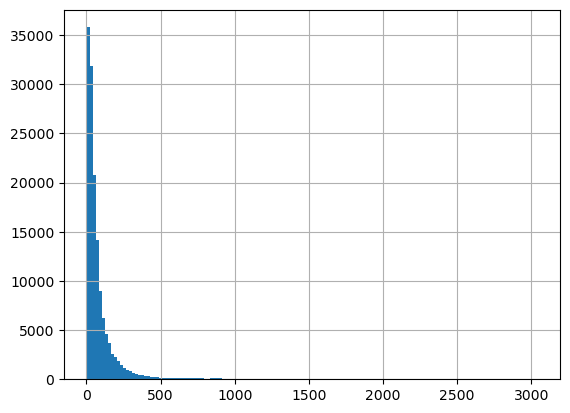

In [37]:
df[df['toxic']==0]['word_count'].hist(bins=150)

<Axes: >

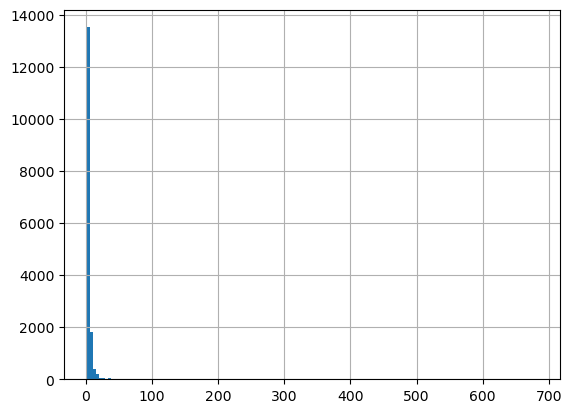

In [38]:
df[df['toxic']==1]['sent_count'].hist(bins=150)

<Axes: >

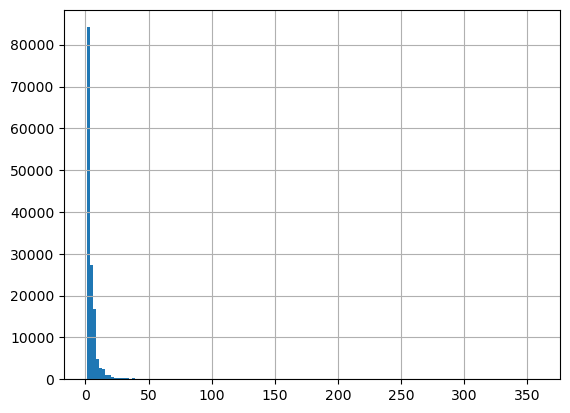

In [39]:
df[df['toxic']==0]['sent_count'].hist(bins=150)

<Axes: >

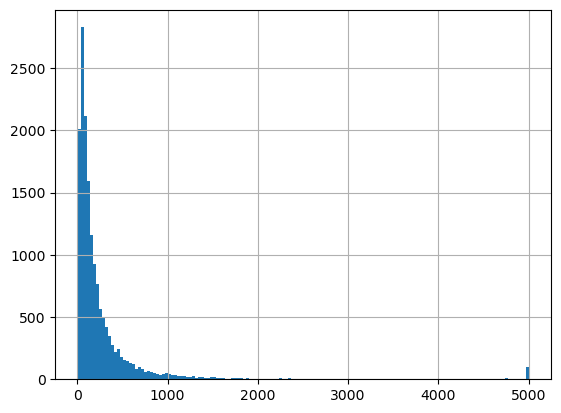

In [40]:
df[df['toxic']==1]['len'].hist(bins=150)

<Axes: >

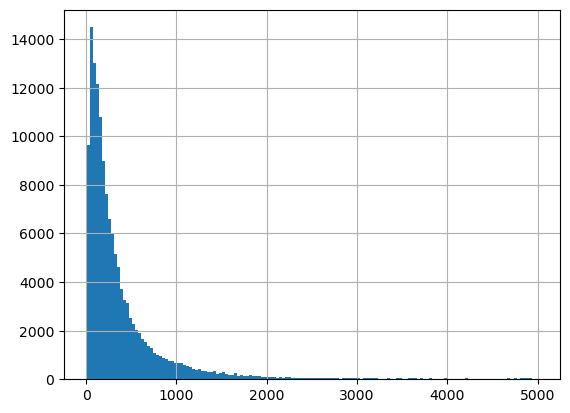

In [41]:
df[df['toxic']==0]['len'].hist(bins=150)

In [42]:
def distribution_plt(df_list, name, val_list, plt_xlim=1):

    x_max = min([series.max() for series in df_list])* plt_xlim

    fig, ax = plt.subplots(2,1,figsize=(10,8))
    ax[0].boxplot([df for df in df_list], vert=False)

    ax[0].set_yticklabels(val_list)
    ax[0].set_xlabel(name)
    ax[0].set_xlim([0, x_max])

    ax[1].hist([df for df in df_list], histtype='stepfilled', bins=500)
    ax[1].set_ylabel('частота')
    ax[1].set_xlabel(name)
    ax[1].set_xlim([0, x_max])

    
    plt.suptitle(f'Ящики с усами и гистограмма для признака "{name}"')
    plt.legend(val_list);
    #plt.xlim((0,x_max))

In [43]:
name_dict = {'word_count' : 'количество слов',
 'sent_count' : 'количество предложений',
 'len' : 'количество символов'}

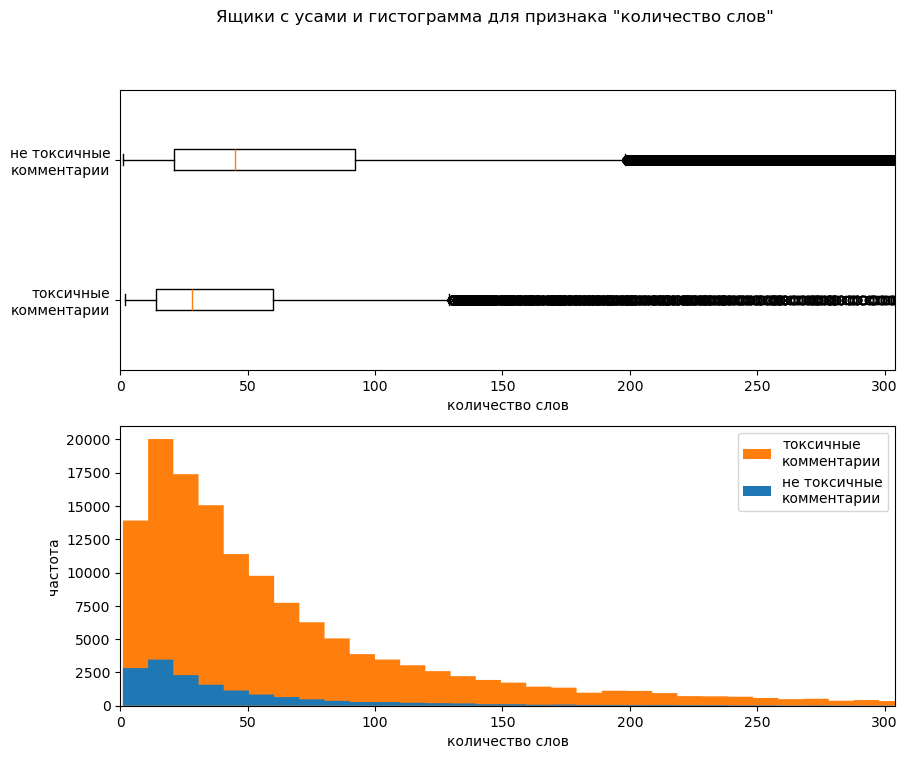

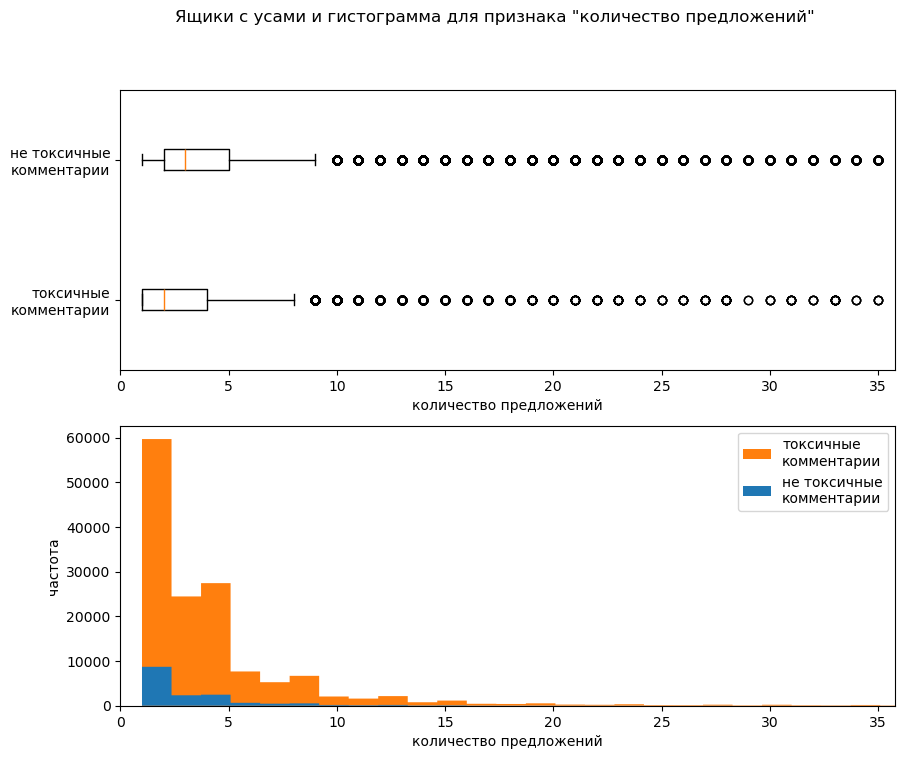

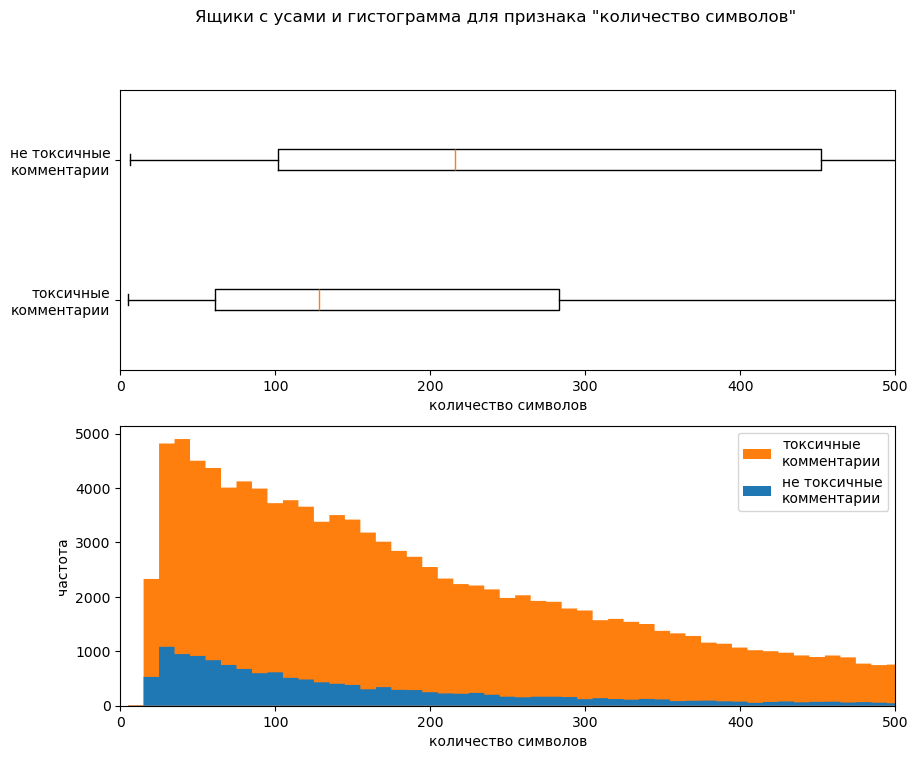

In [44]:
for col in ['word_count', 'sent_count', 'len']:
    
    distribution_plt(
        
        [df[df['toxic']==1][col], df[df['toxic']==0][col]],
        
        name_dict[col],
        
        ['токсичные\nкомментарии', 'не токсичные\nкомментарии'],
        
        0.1)

In [45]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159292 entries, 0 to 159291
Data columns (total 5 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   text        159292 non-null  object
 1   toxic       159292 non-null  int64 
 2   word_count  159292 non-null  int64 
 3   sent_count  159292 non-null  int64 
 4   len         159292 non-null  int64 
dtypes: int64(4), object(1)
memory usage: 6.1+ MB


In [46]:
tokenizer = transformers.DistilBertTokenizer.from_pretrained('distilbert-base-uncased')

In [47]:
tokenizer

DistilBertTokenizer(name_or_path='distilbert-base-uncased', vocab_size=30522, model_max_length=512, is_fast=False, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'}, clean_up_tokenization_spaces=True, added_tokens_decoder={
	0: AddedToken("[PAD]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	100: AddedToken("[UNK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	101: AddedToken("[CLS]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	102: AddedToken("[SEP]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	103: AddedToken("[MASK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
}
)

In [48]:
tokenizer.added_tokens_encoder

{'[PAD]': 0, '[UNK]': 100, '[CLS]': 101, '[SEP]': 102, '[MASK]': 103}

def clean_text(string):

    string = string.strip()
    string = re.sub(r'\[?https?://\S+\]?|\[?www\.\S+\]?', ' [lnkt] ', string)
    string = re.sub(r'\[{1,2}.+\]{1,2}', ' [brct] ', string)
    string = re.sub(r'\{{1,2}.+\}{1,2}', ' {rbrct} ', string)
    #string = re.sub('\\d+\\.?', ' dgtl ', string)
    
    string = re.sub(r'[\_\+\-]',' ',string)
    string = re.sub(r'[^a-zA-Z0-9\s!?.,\[\]\{\}\(\)\:\;]',' ',string)
    string = re.sub(r'\s+', ' ', string)
    
    return string.strip()#.lower()

In [51]:
def clean_text(string):

    string = string.strip()
    string = re.sub(r'\[?https?://\S+\]?|\[?www\.\S+\]?', ' [lnkt] ', string)
    string = re.sub(r'\[{1,2}.+\]{1,2}', ' [brct] ', string)
    string = re.sub(r'\{{1,2}.+\}{1,2}', ' {rbrct} ', string)
    #string = re.sub('\\d+\\.?', ' dgtl ', string)
    
    string = re.sub(r'[\_\+\-]',' ',string)
    string = re.sub(r'[^\w\d\s!?.,\[\]\{\}\(\)\:\;]',' ',string)
    string = re.sub(r'\s+', ' ', string)
    
    return string.strip()#.lower()

In [52]:
def chunker(string):

    sents_ = nl_split(string)

    tokenized_sents = [tokenizer.encode(clean_text(sent), add_special_tokens=True) for sent in sents_]

    usents=[]
    
    for sent in tokenized_sents:
        if sent not in usents and sent!=[101,1012,102] and sent!=[101,102]:
            usents.append(sent)
    
    if len(usents)>1:
       result =  sum(usents, [])
    
    elif len(usents)==1:
        result = usents[0]
    
    else:
        result = tokenizer.encode(sents_[0])

    if len(set(result))/len(string)<0.02:
        result = list(dict.fromkeys(result))
        
    if len(result)>512:
        result = result[:511]+[102]
        #result = result[:129] + result[-382:]+[102]
        
    
    return result

tokenizer.decode(chunker(df['text'][96905]))

tokenizer.decode(chunker(df['text'][4704]))

tokenizer.decode(chunker(df['text'][82496]))

In [53]:
df['first_sent'] = df['text'].swifter.apply(lambda x: nl_split(x)[0])

Pandas Apply:   0%|          | 0/159292 [00:00<?, ?it/s]

In [54]:
df['after_tok'] = df['text'].swifter.apply(lambda x: tokenizer.decode(chunker(x)))

Pandas Apply:   0%|          | 0/159292 [00:00<?, ?it/s]

Token indices sequence length is longer than the specified maximum sequence length for this model (1089 > 512). Running this sequence through the model will result in indexing errors


In [55]:
df['a_t_len'] = df['after_tok'].apply(lambda x: len(x))

In [56]:
df['after_tok'].duplicated().sum()

713

In [57]:
orientation_list = ['gay', 'lesb', 'trans', 'lgbt']
relig_list = ['christ', 'islam', 'judai','budd', 'jesus', 'allah', 'yahweh']
family_list = ['mom', 'dad', 'papa', 'daddy', 'son', 'daughter', 'mother', 'child']

df['orient'] =  df['text'].str.contains('|'.join(orientation_list), flags=re.IGNORECASE)
df['relig'] =  df['text'].str.contains('|'.join(relig_list), flags=re.IGNORECASE)
df['family'] =  df['text'].str.contains('|'.join(family_list), flags=re.IGNORECASE)

In [58]:
df.sort_values(by='after_tok').iloc[50:100]

,text,toxic,word_count,sent_count,len,first_sent,after_tok,a_t_len,orient,relig,family
107720,"""\n\n(2) """"due to strategic and economic reaso...",0,123,7,518,"""",[CLS] ( 2 ) due to strategic and economic reas...,585,False,False,True
101127,(2) How can I be in a minority and a NEW subje...,0,77,7,325,(2) How can I be in a minority and a NEW subject?,[CLS] ( 2 ) how can i be in a minority and a n...,415,False,False,False
75491,(2) How can I raise this issue at Admin Notice...,0,32,2,134,(2) How can I raise this issue at Admin Notice...,[CLS] ( 2 ) how can i raise this issue at admi...,160,False,False,False
140592,"""\n\n(2) The Quackbuster manipulation of Wiki...",0,929,43,4904,"""",[CLS] ( 2 ) the quackbuster manipulation of wi...,2556,False,True,True
78183,(2)Your link (edited out de facto to replace i...,0,29,1,125,(2)Your link (edited out de facto to replace i...,[CLS] ( 2 ) your link ( edited out de facto to...,145,False,False,False
18495,""" (20:50, 19 September 2008)\nCare to offer a...",0,23,2,94,""" (20:50, 19 September 2008)","[CLS] ( 20 : 50, 19 september 2008 ) [SEP] [CL...",127,False,False,True
38965,"(26th Of June, 1928)\nHow America Entered The ...",0,860,27,4700,"(26th Of June, 1928)","[CLS] ( 26th of june, 1928 ) [SEP] [CLS] how a...",2712,False,False,True
5055,(27 Feb 2006 - 6 Apr 2006),0,9,1,26,(27 Feb 2006 - 6 Apr 2006),[CLS] ( 27 feb 2006 6 apr 2006 ) [SEP],38,False,False,False
116171,"""\n\n-\n\n""""(3) The States Parties to the pres...",0,86,2,468,"""",[CLS] ( 3 ) the states parties to the present ...,496,False,False,False
103924,(3) you think what I said constituted a threat...,0,454,18,2140,(3) you think what I said constituted a threat...,[CLS] ( 3 ) you think what i said constituted ...,2337,False,False,False


In [59]:
df.drop_duplicates(subset='after_tok', inplace=True)

In [60]:
df.reset_index(drop=True, inplace=True)

In [61]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 158579 entries, 0 to 158578
Data columns (total 11 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   text        158579 non-null  object
 1   toxic       158579 non-null  int64 
 2   word_count  158579 non-null  int64 
 3   sent_count  158579 non-null  int64 
 4   len         158579 non-null  int64 
 5   first_sent  158579 non-null  object
 6   after_tok   158579 non-null  object
 7   a_t_len     158579 non-null  int64 
 8   orient      158579 non-null  bool  
 9   relig       158579 non-null  bool  
 10  family      158579 non-null  bool  
dtypes: bool(3), int64(5), object(3)
memory usage: 10.1+ MB


In [62]:
def logy(feats, target):
    lr = LogisticRegression(random_state=RANDOM_STATE,max_iter=1000,class_weight='balanced')
    lr.fit(feats, target)
    scores = cross_val_score(lr, feats, target, cv=5, scoring='f1_macro')
    return scores

In [ ]:
1/0

In [ ]:
df.shape[]

In [ ]:
4096*16

In [68]:
samp = df.sample(n=4000, random_state=RANDOM_STATE)

In [66]:
samp[['text','orient','relig','family']]['family'].value_counts()

family
False    3316
True      684
Name: count, dtype: int64

In [69]:
X_train, X_test, y_train, y_test = train_test_split(
    samp[['text','orient','relig','family']],
    samp['toxic'],
    test_size = 0.5,
    random_state = RANDOM_STATE,
    stratify = samp['toxic'])

In [70]:
X_train['family'].value_counts(normalize=1)

family
False    0.833
True     0.167
Name: proportion, dtype: float64

In [71]:
X_test['family'].value_counts(normalize=1)

family
False    0.825
True     0.175
Name: proportion, dtype: float64

In [72]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((2000, 4), (2000, 4), (2000,), (2000,))

In [ ]:
sampler = RandomUnderSampler(random_state=RANDOM_STATE)
X_resample, y_resample = sampler.fit_resample(pd.DataFrame(X_train), pd.DataFrame(y_train)) 

In [ ]:
X_resample.shape, y_resample.shape

In [ ]:
res_df = X_resample.join(y_resample)

In [ ]:
res_samp = res_df.sample(n=10000, random_state=RANDOM_STATE)

In [ ]:
test_samp = pd.DataFrame(X_test).join(pd.DataFrame(y_test)).sample(n=10000, random_state=RANDOM_STATE)

In [ ]:
res_samp.shape

In [ ]:
test_samp.shape

In [73]:
class BertTokenizer(object):

    def __init__(self, text, batch_size=1):
        
        self.text = text
        self.batch_size = batch_size
        #self.model_class ,self.pretrained_weights = (
        #    transformers.BertModel, 'bert-base-uncased')
        self.model_class ,self.pretrained_weights = (
            transformers.DistilBertModel, 'distilbert-base-uncased')    
        
        self.model = self.model_class.from_pretrained(self.pretrained_weights)

    
    def get(self):
        
        tokenized = self.text.swifter.apply(lambda x: chunker(x))
        
        max_len = 0
        
        for tok in tokenized.values:
            if len(tok) > max_len:
                max_len = len(tok)

        padded = np.array([i + [0]*(max_len - len(i)) for i in tokenized.values])
        attention_mask = np.where(padded != 0, 1, 0)
        
        batch_size = self.batch_size
        
        embeddings = []
        
        for i in notebook.tqdm(range(len(padded) // batch_size)):
                batch = torch.LongTensor(padded[batch_size*i:batch_size*(i+1)]) 
                attention_mask_batch = torch.LongTensor(attention_mask[batch_size*i:batch_size*(i+1)])
                
                with torch.no_grad():
                    batch_embeddings = self.model(batch, attention_mask=attention_mask_batch)
                
                embeddings.append(batch_embeddings[0][:,0,:].numpy())
    
        features = np.concatenate(embeddings)

        return features

df[df['text'].str.contains('I ass. I ass.')]['text']

tokenizer.decode(chunker(df['text'][4703]))

tokenizer.decode(chunker(df['text'][0]))

tokenizer.decode(chunker('someone needs to remove lott 71. 227. 167. 147'))

In [ ]:
BertTokenizer(df['text'][0:2]).get()

In [ ]:
res_samp['text'].shape[0]

In [ ]:
###dembs_train = BertTokenizer(text=res_samp['text'], batch_size=50).get()

In [74]:
dembs_train = BertTokenizer(text=X_train['text'], batch_size=50).get()

Pandas Apply:   0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

In [84]:
logy(dembs_train, y_train)

array([0.77162743, 0.80196763, 0.76790451, 0.79834644, 0.84328853])

In [83]:
logy(tr, y_train)

array([0.77155911, 0.79181212, 0.75725209, 0.80196763, 0.84328853])

In [ ]:
#array([0.8919973 , 0.8999975 , 0.90249588, 0.89397286, 0.89449786])

In [ ]:
###dembs_test = BertTokenizer(text=test_samp['text'], batch_size=50).get()
####logy(dembs_train, res_samp['toxic'])

In [85]:
dembs_test = BertTokenizer(text=X_test['text'], batch_size=50).get()

Pandas Apply:   0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

In [86]:
tr = pd.DataFrame(dembs_train).join(pd.DataFrame(X_train.reset_index().iloc[:,2:]))

In [87]:
tr.columns = tr.columns.astype('string')

In [88]:
te = pd.DataFrame(dembs_test).join(pd.DataFrame(X_test.reset_index().iloc[:,2:]))

In [89]:
te.columns = te.columns.astype('string')

array([0.90399962, 0.88947345, 0.87997972, 0.8889929 , 0.89399958])

np.array([0.90499948, 0.89499859, 0.89465875, 0.89533315, 0.89899909]) #last

np.array([0.90499948, 0.89499859, 0.89465875, 0.89533315, 0.89899909]).mean()

np.array([0.90749332, 0.8999999 , 0.89248815, 0.88999989, 0.89946921]).mean()

0.80789152, 0.80608067, 0.80544205, 0.79700029, 0.81400535

from sklearn.utils.class_weight import compute_sample_weight
sample_weights = compute_sample_weight(
    class_weight='balanced',
    y=y_train 
)

sample_weights

In [ ]:
y_train.value_counts(normalize=1)

In [93]:
def f1_eval(y_true, y_pred,):
    #y_true = dtrain.get_label()
    #err = 1 - f1_score(grid_pred, y_test, average=None)[1]
    err = f1_score(y_pred, y_true, average=None)[1]
    return  err

In [94]:
def f1_xgb(y_pred, dtrain):
    y_true = dtrain.get_label()
    err =1 - f1_score(y_true, y_pred, average=None)[1]

    return 'err', err

In [95]:
from sklearn.metrics import make_scorer
my_func = make_scorer(f1_eval, greater_is_better=True)

In [ ]:
y_train.value_counts(normalize=1)

In [ ]:
orientation_list = ['gay', 'lesb', 'trans', 'lgbt']
relig_list = ['christ', 'islam', 'judai','budd']

df['orient'] =  df['text'].str.contains('|'.join(orientation_list), flags=re.IGNORECASE)
df['relig'] =  df['text'].str.contains('|'.join(relig_list), flags=re.IGNORECASE)

In [ ]:
train_nums = df[df.index.isin(res_samp.index)][['a_t_len','sent_count','orient','relig']]
test_nums = df[df.index.isin(y_test.index)][['a_t_len','sent_count','orient','relig']]

In [ ]:
#df[['a_t_len','sent_count','toxic']].phik_matrix(interval_cols=['a_t_len', 'word_count', 'sent_count'])

In [ ]:
debs_no_dups = pd.DataFrame(dembs_train).join(pd.DataFrame(res_samp.reset_index()['toxic'])).join(train_nums.reset_index().iloc[:,1:])
debs_no_dups_test = pd.DataFrame(dembs_test).join(pd.DataFrame(y_test.reset_index()['toxic'])).join(test_nums.reset_index().iloc[:,1:])

In [ ]:
debs_no_dups.columns = debs_no_dups.columns.astype('string')

In [ ]:
debs_no_dups_test.columns = debs_no_dups_test.columns.astype('string')

In [ ]:
debs_no_dups_test.head()

In [ ]:
debs_no_dups['0'][:5]

In [ ]:
debs_no_dups.shape

In [ ]:
debs_no_dups.duplicated().sum()

In [ ]:
debs_no_dups.drop_duplicates(inplace=True)

In [ ]:
debs_no_dups.shape

In [91]:
pipe = Pipeline([('models',[LogisticRegression(random_state=RANDOM_STATE,class_weight='balanced')])])

In [131]:
param_grid = [

    {
        'models': [LogisticRegression(
            random_state=RANDOM_STATE, class_weight='balanced')],
        'models__solver': ['newton-cg', 'liblinear'],
        #'models__class_weight':,
        #'models__C': [0.1, 1]#,
        #'models__penalty': ['l1', 'l2']
          
    },

    {
        'models': [XGBClassifier(
            random_state=RANDOM_STATE,
            scale_pos_weight = 0.892
            
            )],
        'models__n_estimators':[500],#,700],
        'models__max_depth':[8],#[8,9],
        'models__learning_rate':[0.7,0.1],
        'models__eval_metric': [f1_xgb]
    }

]

In [128]:
y_train.value_counts(normalize=1)

toxic
0    0.892
1    0.108
Name: proportion, dtype: float64

In [129]:
param_grid = [

    {
        'models': [LogisticRegression(
            random_state=RANDOM_STATE, class_weight='balanced')],
        'models__solver': ['newton-cg', 'liblinear'],
        #'models__class_weight':,
        #'models__C': [0.1,0.5,1,3,7],
        #'models__penalty': ['l1', 'l2']
          
    }
]

In [132]:
grid_search = GridSearchCV(
    pipe, 
    param_grid, 
    cv=5,
    scoring=my_func,
    n_jobs=-1
)
#grid_search.fit(debs_no_dups.drop('toxic', axis=1), debs_no_dups['toxic'])
grid_search.fit(tr, y_train.values)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('models',
                                        [LogisticRegression(class_weight='balanced',
                                                            random_state=88)])]),
             n_jobs=-1,
             param_grid=[{'models': [LogisticRegression(class_weight='balanced',
                                                        random_state=88)],
                          'models__solver': ['newton-cg', 'liblinear']},
                         {'models': [XGBClassifier(base_score=None,
                                                   booster=None, callbacks=None,
                                                   colsample_bylevel=None,
                                                   c...
                                                   max_leaves=None,
                                                   min_child_weight=None,
                                                   missing=nan,
                                                   monotone_constraints=None,
                                                   multi_strategy=None,
                                                   n_estimators=None,
                                                   n_jobs=None,
                                                   num_parallel_tree=None, ...)],
                          'models__eval_metric': [<function f1_xgb at 0x000001F0D6A38720>],
                          'models__learning_rate': [0.7, 0.1],
                          'models__max_depth': [8],
                          'models__n_estimators': [500]}],
             scoring=make_scorer(f1_eval, response_method='predict'))

In [134]:
pd.DataFrame(grid_search.cv_results_)[['rank_test_score', 'mean_test_score','params']].sort_values('rank_test_score')#.iloc[0]['params']#.head(16)

,rank_test_score,mean_test_score,params
1,1,0.648352,{'models': LogisticRegression(class_weight='ba...
0,2,0.647194,{'models': LogisticRegression(class_weight='ba...
3,3,0.598362,"{'models': XGBClassifier(base_score=None, boos..."
2,4,0.578776,"{'models': XGBClassifier(base_score=None, boos..."


In [98]:
#grid_pred = grid_search.best_estimator_.predict(debs_no_dups_test.drop('toxic', axis=1))

In [135]:
grid_pred = grid_search.best_estimator_.predict(te)

In [137]:
#f1_score(grid_pred, debs_no_dups_test['toxic'],average=None)

In [138]:
f1_score(grid_pred, y_test.values,average=None)

array([0.93833624, 0.6227758 ])

In [ ]:
print(classification_report(grid_pred, debs_no_dups_test['toxic']))

In [139]:
classifier_other_threshold = FixedThresholdClassifier(
    grid_search.best_estimator_, threshold=0.78, response_method="predict_proba"
).fit(tr, y_train.values)
f1_score(y_test.values, classifier_other_threshold.predict(te))

0.6904761904761905

In [ ]:
classifier_other_threshold = FixedThresholdClassifier(
    grid_search.best_estimator_, threshold=0.6, response_method="predict_proba"
).fit(debs_no_dups.drop('toxic', axis=1), debs_no_dups['toxic'])
f1_score(debs_no_dups_test['toxic'], classifier_other_threshold.predict(debs_no_dups_test.drop('toxic', axis=1)))#,average=None)#82

In [ ]:
pd.DataFrame(dembs_train).duplicated().sum()

In [ ]:
f1_score(y_test, classifier_other_threshold.predict(dembs_test))#82

In [ ]:
cl_preds_adj = classifier_tuned.predict(dembs_val)

In [ ]:
f1_score(cl_preds_adj,y_val)

In [ ]:
res =pd.DataFrame({'a':grid_pred, 'b':test_sample['toxic']})

In [ ]:
pd.DataFrame(probs[0])

In [ ]:
y_test.shape

In [ ]:
pd.DataFrame({'proba':list(probs[1])},
              {'predicted':grid_pred})

In [ ]:
probs_res = pd.DataFrame(zip(y_test,probs[1],grid_pred),columns=['toxic', 'proba', 'pred'])

In [ ]:
probs_res[(probs_res['toxic']!=probs_res['pred']&(probs_res['toxic']==1))]['proba']

In [ ]:
X_test.iloc[1961]

In [ ]:
X_train.apply(lambda x: len(x)).hist()

In [ ]:
X_train.shape

In [ ]:
X_resample.shape

In [ ]:
X_train[X_train.apply(lambda x: len(x))>2000]

In [ ]:
res.shape

In [ ]:
df['text'].

In [ ]:
df[(df.index.isin(res[res['a']!=res['b']].index))&(df['toxic']==1)]['text'].apply(lambda x: tokenizer.decode(chunker(x)))#.sample()



#['b'].value_counts()

In [ ]:
tokenizer.decode(chunker(df.loc[128933]['text']))

In [ ]:
df.loc[128933]['text']

## Обучение

In [ ]:
#from phik.report import plot_correlation_matrix
#from phik import phik_matrix

In [ ]:
#df.info()

phik_overview = phik_matrix(df[['toxic','word_count']],verbose=False)

plot_correlation_matrix(
    phik_overview.values,
    x_labels=phik_overview.columns,
    y_labels=phik_overview.index,
    vmin=0, vmax=1, color_map='Blues',
    title=r'correlation $\phi_K$',
    fontsize_factor=1.5,
    figsize=(18, 14)
) 

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    df['text_lemm'], 
    df['toxic'], 
    random_state=RANDOM_STATE,
    stratify=df['toxic']
)

In [ ]:
sampler = RandomUnderSampler(random_state=RANDOM_STATE)
X_resample, y_resample = sampler.fit_resample(pd.DataFrame(X_train), pd.DataFrame(y_train)) 


In [ ]:
y_resample.value_counts()

In [ ]:
pd.DataFrame(y_test).value_counts()

## Выводы

## Чек-лист проверки

- [x]  Jupyter Notebook открыт
- [ ]  Весь код выполняется без ошибок
- [ ]  Ячейки с кодом расположены в порядке исполнения
- [ ]  Данные загружены и подготовлены
- [ ]  Модели обучены
- [ ]  Значение метрики *F1* не меньше 0.75
- [ ]  Выводы написаны